In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib


# Notification
import time

# File IO
import h5py
import os

# Deep learning
# Keras-related imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution1D, MaxPooling2D, Convolution2D
from keras import backend as K
# K.set_image_dim_ordering('th')
from keras.callbacks import ModelCheckpoint
from keras.callbacks import RemoteMonitor
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D


# Result processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score


C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning

# Section 0: Perform feature transform, save data

This section is used to create the $(\mathbf{X},y)$ training set with feature choice parameterised by either `{'log-mel', 'mfcc'}`. Librosa is used to extract the features, and has further support for any features one may wish to choose.

Once this section has been run once, the user is advised to skip to **Section 1** which deals with performing a baseline classification using a Convolutional Neural Network.

In [15]:
# Parameterise feature transform here. The default is to use log-mel features, but the user may implement any choice
# or use the raw time-series as preferred 

feature_type = 'log-mel'  # Select from {'log-mel', 'mfcc'}


win_len = 0.1  # Window length of feature
n_mels = 128  # Number of log-mel coefficients

In [16]:
# Select the root of the processed 1 second audio chunks, where votes have been aggregated already
# This path is relative, and should by default point to the correct location

wav_root = '../data/audio_1sec/'  

In [17]:
# Load the label information contained in the resolved 1 second chunks, with votes {'yes', 'no', 'not_sure'}

df = pd.read_csv('../labels/audio_1sec.csv',  header=None, names=["path", "yes", "no", "not_sure","subject_set"])
df['path'] = df['path'].astype(str) + '.wav'


# Create the y vector by treating 'not_sure' as 0.5, 'yes' as 1.0, 'no' as 0.0 and average
df['res'] = (df['yes'].astype(int)*1 + df['not_sure'].astype(int)*0.5) / (df['yes'] + df['no'] + df['not_sure']) >= 0.5
total_audio_n = len(df.index.values.tolist())

y = np.zeros((total_audio_n, 2))

y[:,1] = np.array(np.array(df['res']).astype(int)).astype(int)
y[:,0] = 1-y[:,1].astype(int)

In [18]:
# Initialise dimensions for feature transformation

nfft = int(win_len * 8000)
wav_path = wav_root + df["path"]

# Initialise empty X matrix
wav, fs = librosa.load(wav_path.iloc[0],sr=None)  # Load one spectrogram file to calculate dimensions of entire set

if feature_type == 'log-mel':    
    spec = librosa.feature.melspectrogram(y=wav, sr=fs, n_mels=n_mels, n_fft=nfft*4, hop_length=nfft)
             
elif feature_type == 'mfcc':
    spec = librosa.feature.mfcc(y=wav, sr=fs, n_mfcc=13, n_fft=nfft*4, hop_length=nfft)
    
l_spec = np.shape(spec)[1]  # Length of the spectral representation for each 2 second chunk
h_spec = np.shape(spec)[0]  # This is also n_mels
spec_matrix = np.zeros([len(y), h_spec, l_spec])  

In [19]:
# Perform feature transformation and store result in pre-allocated spec_matrix

start_time = time.time()
for i in range(0, total_audio_n):
#     if count[i] == 1:
        
        # Create X matrix
    audio_file, fs = librosa.load(wav_path.loc[i],sr=None)
    if feature_type == 'log-mel':
        spec_matrix[i] = librosa.feature.melspectrogram(y=audio_file,
                                                        sr=fs, n_mels=n_mels, n_fft=nfft*4, hop_length=nfft)

    elif feature_type == 'mfcc':
        spec_matrix[i] = librosa.feature.mfcc(y=audio_file,
                                                        sr=fs, n_mfcc=13, n_fft=nfft*4, hop_length=nfft)            
        
    if i%1000 == 0:
        time_used = time.time()-start_time
        time_total = time_used * total_audio_n / (i+1)
        
        print('Iteration', str(i), "%i"%(time_used), "%i"%(time_total))



Iteration 0 0 1052
Iteration 1000 6 486
Iteration 2000 12 501
Iteration 3000 18 499
Iteration 4000 25 498
Iteration 5000 31 498
Iteration 6000 37 497
Iteration 7000 43 497
Iteration 8000 49 497
Iteration 9000 56 497
Iteration 10000 62 497
Iteration 11000 68 498
Iteration 12000 75 498
Iteration 13000 81 498
Iteration 14000 87 498
Iteration 15000 93 499
Iteration 16000 100 499
Iteration 17000 106 499
Iteration 18000 112 499
Iteration 19000 119 499
Iteration 20000 125 499
Iteration 21000 131 500
Iteration 22000 138 500
Iteration 23000 144 500
Iteration 24000 150 500
Iteration 25000 157 500
Iteration 26000 163 499
Iteration 27000 169 499
Iteration 28000 175 499
Iteration 29000 181 499
Iteration 30000 188 499
Iteration 31000 194 499
Iteration 32000 200 500
Iteration 33000 207 500
Iteration 34000 213 500
Iteration 35000 220 500
Iteration 36000 226 500
Iteration 37000 232 500
Iteration 38000 238 500
Iteration 39000 245 500
Iteration 40000 251 500
Iteration 41000 257 500
Iteration 42000 263 50

In [20]:
# Save files with file_name if not in path

file_names = ['data_log-melnot_sure_single_into_0_5.h5', 'label_log-melnot_sure_single_into_0_5.h5']

for file_name in file_names:
    if not os.path.isfile('../proc_data/' + file_name):
        hf = h5py.File('../proc_data/data_' + feature_type + 'not_sure_single_into_0_5.h5', 'w')
        hf.create_dataset('../proc_data/data_' + feature_type + '_majority_labels_not_sure_single_into_0_5',
                          data=spec_matrix)
        hf.close()
        
        hf = h5py.File('../proc_data/label_' + feature_type + 'not_sure_single_into_0_5.h5', 'w')
        hf.create_dataset('../proc_data/label_' + feature_type + '_majority_labels_not_sure_single_into_0_5', data=y)
        hf.close()

# Section 1: Load and classify

If the feature transform has already been performed and the data is saved in `proc_data`, load the data in the cell below and perform classification as outlined by the following cells.

In [3]:
# Load files
feature_type = 'log-mel'
save_name = 'not_sure_single_into_0_5'

hf = h5py.File('../proc_data/data_' + feature_type + save_name + '.h5', 'r')
spec_matrix_read = np.array(hf.get('../proc_data/data_' + feature_type + '_majority_labels_' + save_name))
hf.close()

hf = h5py.File('../proc_data/label_' + feature_type + save_name + '.h5', 'r')
y = np.array(hf.get('../proc_data/label_' + feature_type + '_majority_labels_' + save_name))
hf.close()


# Create dataset 


In [4]:
# Convert to dB

spec_matrix_db = np.zeros_like(spec_matrix_read)

for i, spec in enumerate(spec_matrix_read):
    spec_matrix_db[i] = librosa.power_to_db(spec,ref=np.max)

## Train Convolutional Neural Network

First, the data is split tenfold using `sklearn`'s `train_test_split` with the random states given in the `random_state` vector.

The neural network cross-entropy weights are set in the dictionary `class_weight`, with the key `0` referring to the noise class, and `1` referring to the mosquito class



Epoch 1/3
53373/53373 [==============================] - 9s 174us/step - loss: 1.0211 - accuracy: 0.7780
Epoch 2/3
53373/53373 [==============================] - 8s 142us/step - loss: 0.9533 - accuracy: 0.8113
Epoch 3/3
53373/53373 [==============================] - 8s 141us/step - loss: 0.9401 - accuracy: 0.8160
10 0.4947720469075895 0.8071436882019043
Epoch 1/3
53373/53373 [==============================] - 8s 141us/step - loss: 1.0288 - accuracy: 0.7740
Epoch 2/3
53373/53373 [==============================] - 7s 137us/step - loss: 0.9582 - accuracy: 0.8038
Epoch 3/3
53373/53373 [==============================] - 7s 136us/step - loss: 0.9385 - accuracy: 0.8161
20 0.4633132185622726 0.8548442125320435
Epoch 1/3
53373/53373 [==============================] - 8s 142us/step - loss: 1.0040 - accuracy: 0.7813
Epoch 2/3
53373/53373 [==============================] - 7s 139us/step - loss: 0.9406 - accuracy: 0.8086
Epoch 3/3
53373/53373 [==============================] - 7s 139us/step - los

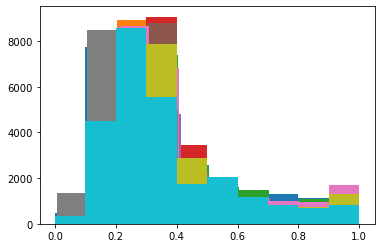

In [5]:
pred_list = []
y_test_list = []

for random_state in [10,20,30,40,50,60,70,80,90,100]:

    X_train, X_test, y_train, y_test = train_test_split(spec_matrix_db, np.array(y), test_size=0.33,
                                                        random_state=random_state)
    # Normalise by statistics of training data
    X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)
    X_test_norm = (X_test - np.mean(X_train))/np.std(X_train)
    X_train_tf = X_train_norm.reshape(X_train_norm.shape[0], 1, X_train_norm.shape[1], X_train_norm.shape[2])
    X_test_tf = X_test_norm.reshape(X_test_norm.shape[0], 1, X_test_norm.shape[1], X_test_norm.shape[2])

    ################################ CONVOLUTIONAL NEURAL NETWORK ################################
    ## NN parameters
    class_weight = {0: 1.,
                    1: 10.,
                    }
    input_shape = (1, X_train_tf.shape[2], X_train_tf.shape[-1])

    model = Sequential()
    n_dense = 128
    nb_classes = 2
    # number of convolutional filters
    nb_conv_filters = 32
    # num_hidden = 236
    nb_conv_filters_2 = 64
    convout1 = Activation('relu')
    convout2 = Activation('relu')

    model.add(Conv2D(nb_conv_filters, kernel_size = (3,3),
         activation = 'relu', padding = 'valid', strides = 1,
         input_shape = input_shape))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
         activation = 'relu', padding = 'valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # model.add(Conv2D(nb_conv_filters_2, kernel_size = (5,5),
    #      activation = 'relu', padding = 'valid'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.2))  
    model.add(Flatten())
    # Shared between MLP and CNN:
    model.add(Dense(n_dense, activation='relu'))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                    optimizer='adadelta',
                    metrics=['accuracy'])

    model.fit(x=X_train_tf, y=y_train, batch_size=None, epochs=3, verbose=1, callbacks=None, validation_split=0.0,
              validation_data=None,
              shuffle=True, class_weight=class_weight, sample_weight=None, initial_epoch=0,
              steps_per_epoch=None, validation_steps=None)


    loss, acc = model.evaluate(x=X_test_tf, y=y_test, batch_size=None, verbose=0, sample_weight=None, steps=None)
    pred = model.predict(X_test_tf)
    plt.hist(pred[:,1]) # Optional: visualise histogram of labels
#     plt.show()
    print(random_state, loss, acc)
    
    pred_list.append(pred)  # Collect y_test to report classification performance
    y_test_list.append(y_test)  # Collect y_test to report classification performance

    
    

## Create plotting functions

We now create a function to display the confusion matrices. This is a slight modification of the `plot_confusion_matrix` function available on [sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) to include a mean and variance, for the purpose of evaluation over a tenfold split.

In [6]:
def plot_confusion_matrix(cm, classes, std,
                          normalize=False,
                                                    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


    std = std * 100
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] *100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,

           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt) + ' ± ' + format(std[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


cm_list = []
for i in np.arange(len(pred_list)):
        cm_list.append(confusion_matrix(np.argmax(y_test_list[i],-1), np.argmax(pred_list[i],-1)))
cm_mean = np.mean(cm_list, axis = 0)
total = np.sum(cm_mean)
cm_mean = cm_mean/total
cm_std = np.std(cm_list, axis = 0)/total


## Format and display plot

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Normalized confusion matrix
[[85.36 14.64]
 [29.04 70.96]]


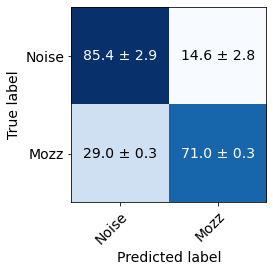

In [7]:
np.set_printoptions(precision=2)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


class_names= np.array(['Noise', 'Mozz'])

# Plot normalized confusion matrix
plot_confusion_matrix(cm_mean, std=cm_std, classes=class_names, normalize=True)
plt.tight_layout()
plt.show()